
**Scientific Programming with Python: Assignment 3**
Presenters:
1. Moohammed Sattar - R00259436
2. Annu Sharma - R00259722
3. Karthik Pillai - R00258774

Data Set: Superstore

Importing the required Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

Reading in the dataset as a Pandas Dataframe


In [2]:
df=pd.read_csv("superstore.csv")
temp_df=df.copy()
coor= df.copy()

Removing Miscellaneous(Unwanted) columns

In [3]:
temp_df.pop("Unnamed: 0") # Dosen't provide any useful information
temp_df.pop("记录数") # Dosen't provide any useful information
temp_df.pop("Row.ID") # Reduntant column that provides the row number
print(temp_df.columns)

Index(['Category', 'City', 'Country', 'Customer.ID', 'Customer.Name',
       'Discount', 'Market', 'Order.Date', 'Order.ID', 'Order.Priority',
       'Product.ID', 'Product.Name', 'Profit', 'Quantity', 'Region', 'Sales',
       'Segment', 'Ship.Date', 'Ship.Mode', 'Shipping.Cost', 'State',
       'Sub.Category', 'Year', 'Market2', 'weeknum'],
      dtype='object')


Rearraging the columns for convenience

In [4]:
columns = [
    # Order Details
    "Order.ID", "Order.Date", "Year", "weeknum", "Ship.Date", "Order.Priority", "Ship.Mode", "Shipping.Cost",
    # Customer Details
    "Customer.ID", "Customer.Name", "Segment",
    # Location Details
    "City", "State", "Country","Region",
    # Product Details
    "Product.ID", "Product.Name", "Category", "Sub.Category",
    # Sales and Financials
    "Quantity", "Sales", "Discount", "Profit",
    # Market Details
    "Market", "Market2"
]
temp_df=temp_df[columns]

In [5]:
temp_df.isna().sum()

Order.ID          304
Order.Date        205
Year              112
weeknum             0
Ship.Date         373
Order.Priority    133
Ship.Mode         468
Shipping.Cost     474
Customer.ID       226
Customer.Name     426
Segment           427
City              246
State             415
Country           407
Region            411
Product.ID        290
Product.Name       31
Category          119
Sub.Category      276
Quantity          148
Sales             177
Discount          466
Profit            327
Market            222
Market2            48
dtype: int64

Cleaning the dataset:
Starting with data type conversion

In [6]:
# Changing Datatype of Object to String for the concerning factors
for i in temp_df.columns:
    if(temp_df[i].dtypes=='object'):
        temp_df[i]=temp_df[i].astype("string")
temp_df['Order.Date']=pd.to_datetime(temp_df['Order.Date'])
temp_df['Ship.Date']=pd.to_datetime(temp_df['Ship.Date'])

#setting the dataframe index to show number of observation and sorting w.r.t. Order.Date
temp_df=temp_df.sort_values(by='Order.Date', ascending=False)
temp_df.reset_index()
temp_df.set_index(np.arange(0,len(temp_df)), inplace=True)

Discarding observations where the shipping date is earlier than the order date

In [7]:
before_cleaing=len(temp_df)
temp_df = temp_df[temp_df['Ship.Date'] >= temp_df['Order.Date']]

# Checking for duplicate entries
print(f"Number of Duplicate rows: {df.duplicated().sum()}")
print(f"Number of Observations after removing duplicates and rows with wrong Shipping Date: {len(temp_df)}")
print(f"Data lost after the above step: {round((before_cleaing-len(temp_df))/before_cleaing*100, 2)}%")

Number of Duplicate rows: 0
Number of Observations after removing duplicates and rows with wrong Shipping Date: 50715
Data lost after the above step: 1.12%


Handling the missing values

In [8]:
#Market and Market2

M1=temp_df["Market"].dropna().unique().tolist()
M2=temp_df["Market2"].dropna().unique().tolist()
M2.append("North America")
for i in range(len(M1)):
    temp_df.loc[temp_df["Market"].isna() & (temp_df["Market2"]==M2[i]), "Market"] = M1[i]
    temp_df.loc[temp_df["Market2"].isna() & (temp_df["Market"]==M1[i]), "Market2"] = M2[i]
temp_df.pop('Market2') # Reduntant column

0          APAC
1        Africa
2         LATAM
3         LATAM
4            EU
          ...  
51080      APAC
51081      APAC
51082        EU
51083      APAC
51084    Africa
Name: Market2, Length: 50715, dtype: string

Creating a map to fill out missing location information

In [9]:
#Location data
location=temp_df.loc[:,['City', 'State', 'Country', 'Region']].drop_duplicates()
loc_u=location.dropna()

In [10]:
# Merging temp_df with location on 'City' and 'State'
merged_df_Country = temp_df.merge(loc_u, on=['City', 'State', 'Region'], how='left', suffixes=('', '_loc'))
merged_df_State = temp_df.merge(loc_u, on=['Country', 'City',  'Region'], how='left', suffixes=('', '_loc'))


# Filling missing 'Country' values in temp_df with the values from loc_u
temp_df['Country'] = temp_df['Country'].fillna(merged_df_Country['Country_loc'])
temp_df['State'] = temp_df['State'].fillna(merged_df_State['State_loc'])


# Check for missing values in 'Region'
missing_region = temp_df[temp_df['Region'].isna()]
unique_regions = temp_df[['Country', 'Region']].dropna()
mapping = unique_regions.set_index(['Country'])['Region'].to_dict()
temp_df['Region'] = temp_df.apply(
    lambda row: mapping.get((row['Country']), row['Region']),
    axis=1
)
temp_df['State']=temp_df['State'].fillna('Unknown')
temp_df['Country']=temp_df['Country'].fillna('Unknown')

Updating the Customer ID and Name columns with existing data map

In [11]:
# Checking for missing values in 'Customer.ID'
missing_id = temp_df[temp_df['Customer.ID'].isna()]

# Finding unique customer information in the DataFrame
unique_id = temp_df[['Customer.ID', 'City', 'State', 'Country', 'Region', 'Customer.Name']].dropna()

# Creating a mapping for missing 'Customer.Name'
mapping = unique_id.set_index(['Customer.Name', 'City', 'State', 'Country', 'Region'])['Customer.ID'].to_dict()

temp_df['Customer.ID'] = temp_df.apply(
    lambda row: mapping.get((row['Customer.Name'], row['City'], row['State'], row['Country'], row['Region']), row['Customer.ID']),
    axis=1
)

print(temp_df['Customer.ID'].isna().sum())
temp_df['Customer.ID']=temp_df['Customer.ID'].fillna('Unknown')

55


In [12]:
# Check for missing values in 'Customer.Name'
missing_names = temp_df[temp_df['Customer.Name'].isna()]
unique_customers = temp_df[['Customer.ID', 'City', 'State', 'Country', 'Region', 'Customer.Name']].dropna()
mapping = unique_customers.set_index(['Customer.ID', 'City', 'State', 'Country', 'Region'])['Customer.Name'].to_dict()

#filling missing values in 'Customer.Name'
temp_df['Customer.Name'] = temp_df.apply(
    lambda row: mapping.get((row['Customer.ID'], row['City'], row['State'], row['Country'], row['Region']), row['Customer.Name']),
    axis=1
)

temp_df['Customer.Name']=temp_df['Customer.Name'].fillna('Unknown')
print(temp_df['Customer.Name'].isna().sum())

0


Filling of missing values in year column using the Order.Date column

In [13]:
#Order Date
temp_df['Year'] = np.where(temp_df['Year'].isna(), pd.DatetimeIndex(temp_df['Order.Date']).year, temp_df['Year'])

Filling of missing values in Category and prduct name and ID 

In [ ]:
temp_df["Product.ID"]=temp_df["Product.ID"].fillna("0")
cat1=temp_df.loc[:,['Category', 'Sub.Category', 'Product.Name', 'Product.ID']].dropna().drop_duplicates()

merged_df_Cat = temp_df.merge(cat1, on=['Product.Name'], how='left', suffixes=('', '_fill'))
temp_df['Category'] = temp_df['Category'].fillna(merged_df_Cat['Category_fill'])

merged_df_Pname = temp_df.merge(cat1, on=['Category', 'Product.ID'], how='left', suffixes=('', '_fill'))
temp_df['Product.Name'] = temp_df['Product.Name'].fillna(merged_df_Pname['Product.Name_fill'])

merged_df_Scat = temp_df.merge(cat1, on=['Category', 'Product.Name'], how='left', suffixes=('', '_fill'))
temp_df['Sub.Category'] = temp_df['Sub.Category'].fillna(merged_df_Scat['Sub.Category_fill'])

Filling missing values for Order and Product data

In [15]:
before=len(temp_df)

temp_df=temp_df.dropna(subset=['Sales','Profit', 'City'])

temp_df["Order.ID"]= temp_df["Order.ID"].fillna("0")

temp_df['Segment']= temp_df['Segment'].fillna(temp_df['Segment'].mode()[0])

temp_df['Ship.Mode']= temp_df['Ship.Mode'].fillna(temp_df['Ship.Mode'].mode()[0])

temp_df['Order.Priority']= temp_df['Order.Priority'].fillna(temp_df['Order.Priority'].mode()[0])

temp_df['Shipping.Cost']= temp_df['Shipping.Cost'].fillna(round(temp_df['Shipping.Cost'].mean(),2))

temp_df['Quantity']= temp_df['Quantity'].fillna(round(temp_df['Quantity'].mean()))

temp_df['Discount']= temp_df['Discount'].fillna(round(temp_df['Discount'].mean()))

Finding the amount of data lost after cleaning and doing a final check for missing or NA values

In [16]:
cleaned_df=temp_df.copy()
after=len(cleaned_df)
print(f"Data lost after cleaning: {round((before-after)/before*100, 2)}%")
print(cleaned_df.isna().sum(), len(cleaned_df))

Data lost after cleaning: 1.46%
Order.ID          0
Order.Date        0
Year              0
weeknum           0
Ship.Date         0
Order.Priority    0
Ship.Mode         0
Shipping.Cost     0
Customer.ID       0
Customer.Name     0
Segment           0
City              0
State             0
Country           0
Region            0
Product.ID        0
Product.Name      0
Category          0
Sub.Category      0
Quantity          0
Sales             0
Discount          0
Profit            0
Market            0
dtype: int64 49973


Saving the Cleaned DataFrame to a csv

In [17]:
cleaned_df.to_csv('CleanedSuperStore.csv', index=False)

Phase II - EDA

In [18]:
#creating a copy of dataset for EDA
EDA_df=cleaned_df.copy()

Basic descriptives of numerical columns in the dataset

In [19]:
EDA_df.describe()

,Order.Date,Year,weeknum,Ship.Date,Shipping.Cost,Quantity,Sales,Discount,Profit
count,49973,49973.000000,49973.000000,49973,49973.000000,49973.000000,49973.000000,49973.000000,49973.000000
mean,2013-05-12 05:48:55.657254912,2012.778260,31.282152,2013-05-16 05:06:09.919756544,26.388499,3.473516,246.841034,0.141672,28.738938
min,2011-01-01 00:00:00,2011.000000,1.000000,2011-01-03 00:00:00,0.002000,1.000000,0.000000,0.000000,-6599.978000
25%,2012-06-19 00:00:00,2012.000000,20.000000,2012-06-23 00:00:00,2.650000,2.000000,31.000000,0.000000,0.000000
50%,2013-07-08 00:00:00,2013.000000,33.000000,2013-07-12 00:00:00,7.960000,3.000000,85.000000,0.000000,9.255200
75%,2014-05-23 00:00:00,2014.000000,44.000000,2014-05-26 00:00:00,25.360000,5.000000,251.000000,0.200000,36.840000
max,2014-12-31 00:00:00,2014.000000,53.000000,2015-01-07 00:00:00,933.570000,14.000000,22638.000000,0.850000,8399.976000
std,NaN,1.098615,14.432617,NaN,56.927074,2.273961,489.223948,0.211873,174.881552


Exploring the data distribution

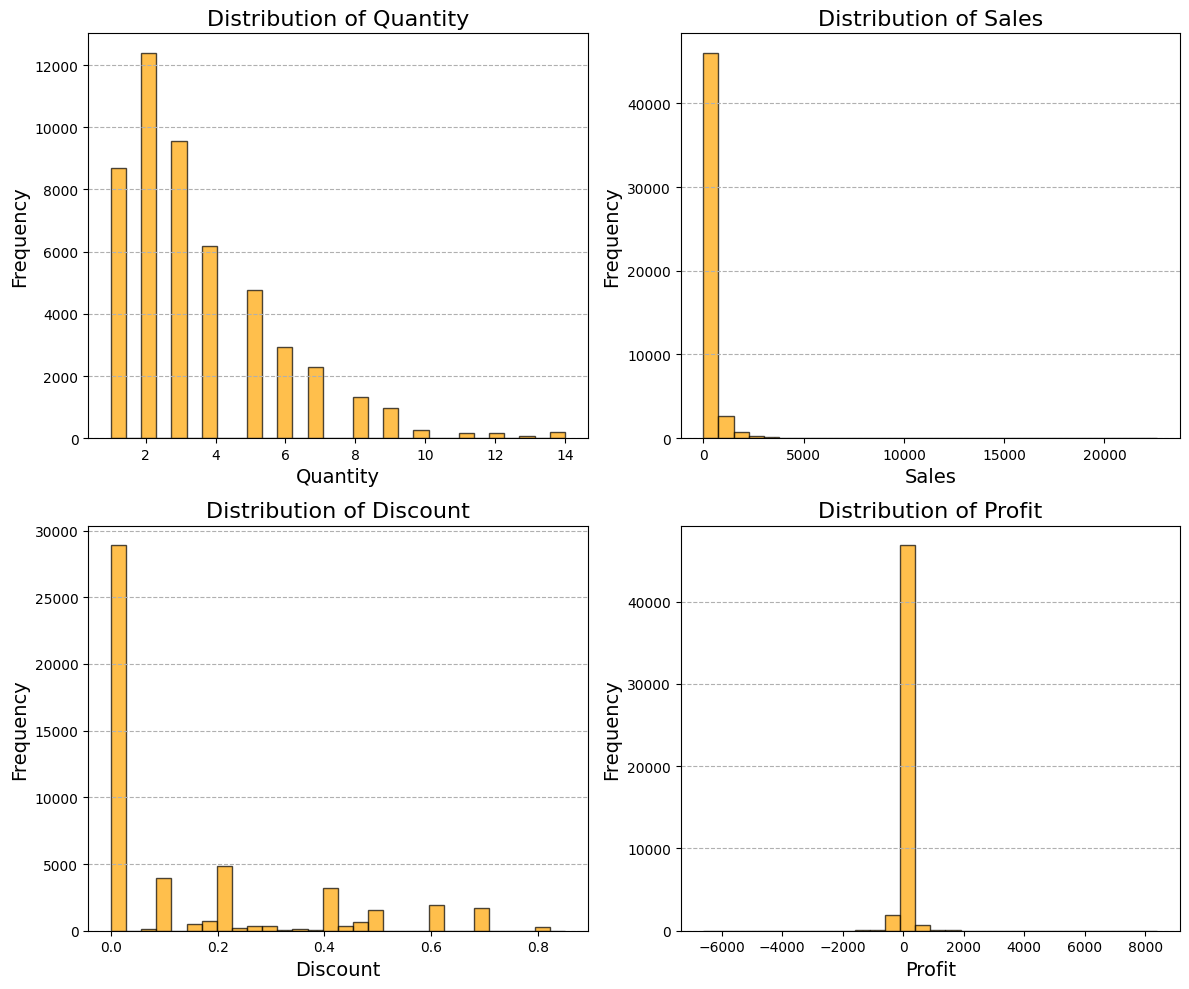

In [20]:
numerical_columns = ['Quantity', 'Sales', 'Discount', 'Profit']

# Create a grid of subplots (2 rows and 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
# Loop through the numerical columns and plot each histogram in a subplot
for i, col in enumerate(numerical_columns):
    axes[i].hist(EDA_df[col], bins=30, color='Orange', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}', fontsize=16)
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].set_ylabel('Frequency', fontsize=14)
    axes[i].grid(axis='y', linestyle='--')

plt.tight_layout()

# Show the plot
plt.show()

Creating a Correlation Matrix

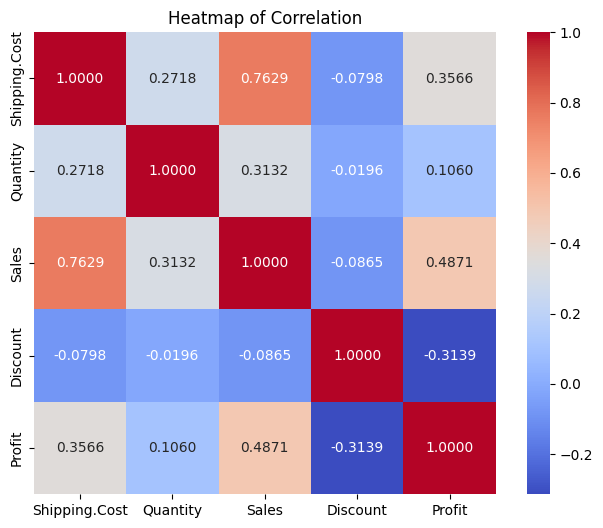

In [21]:
numerical_columns = ['Shipping.Cost', 'Quantity', 'Sales', 'Discount', 'Profit']
correlation_matrix = EDA_df[numerical_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', cbar=True, square=True)
plt.title('Heatmap of Correlation', fontsize=12)
plt.show()

Finding  which Categories and Sub.Categories make the top 6 list

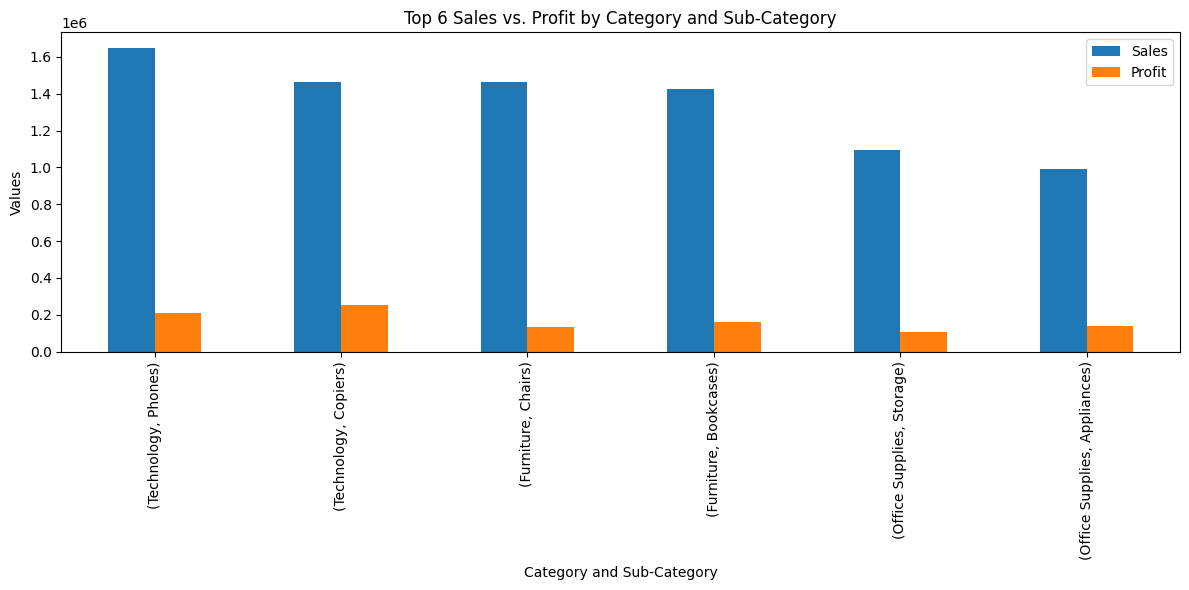

In [22]:
# Groupping data by Category and Sub-Category, summing Sales and Profit
category_profit_sales = EDA_df.groupby(['Category', 'Sub.Category'])[['Sales', 'Profit']].sum()
#the top 5 by Sales
top_sales = category_profit_sales.nlargest(5, 'Sales')
#top 5 by Profit
top_profit = category_profit_sales.nlargest(5, 'Profit')
top_5_sales_profit = pd.concat([top_sales, top_profit]).drop_duplicates()

#Plotting the data
top_5_sales_profit.plot(kind='bar', figsize=(12, 6))
plt.title('Top 6 Sales vs. Profit by Category and Sub-Category')
plt.xlabel('Category and Sub-Category')
plt.ylabel('Values')
plt.tight_layout()
plt.show()


Here the top product by sales is apple smart phone, this has been purchased by most of the customers but the profit is generated by the sell of product Advance Copier.

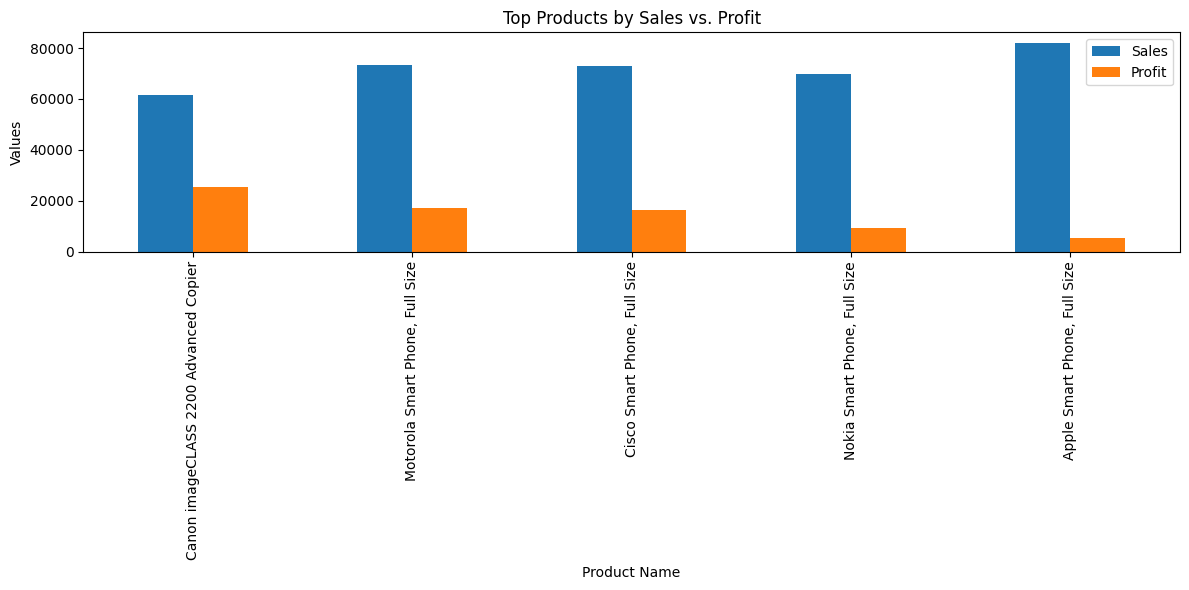

In [23]:
# Group by Product and sum Sales and Profit
top_products = EDA_df.groupby('Product.Name')[['Sales', 'Profit']].sum().nlargest(5, 'Sales').sort_values(by= 'Profit', ascending=False)
# Plot
top_products.plot(kind='bar', figsize=(12, 6))
plt.title('Top Products by Sales vs. Profit')
plt.xlabel('Product Name')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

This plot shows which region had the maximum sales, here it is visible that the North asia and south asia has the highest sales.

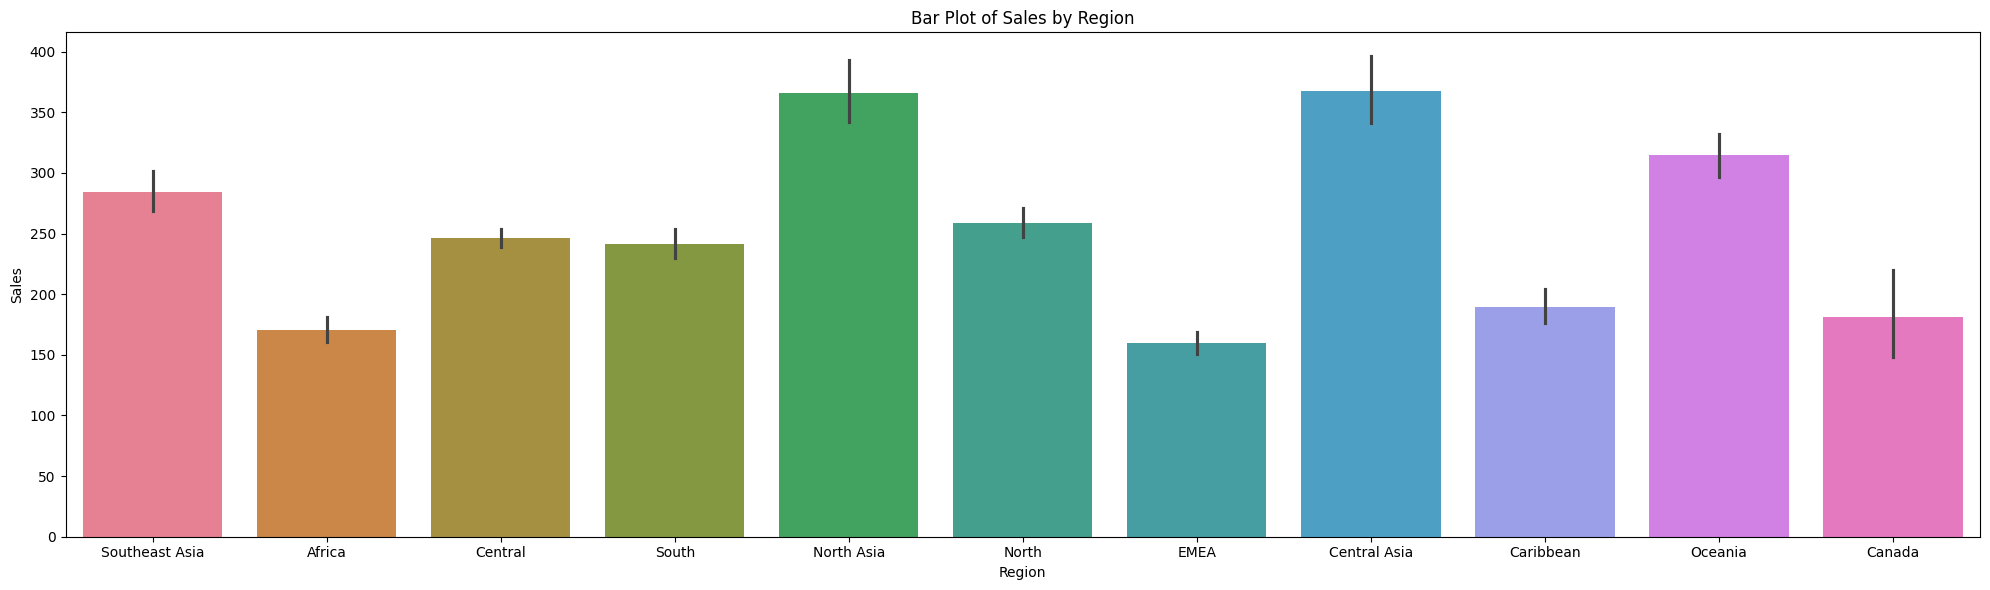

In [24]:
plt.figure(figsize=(20, 6))
sns.barplot(x='Region', y='Sales', data=EDA_df, hue="Region")
plt.title('Bar Plot of Sales by Region')
plt.xlabel('Region')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

This pie chart is showing which country has the maximum sales from the above top two regions

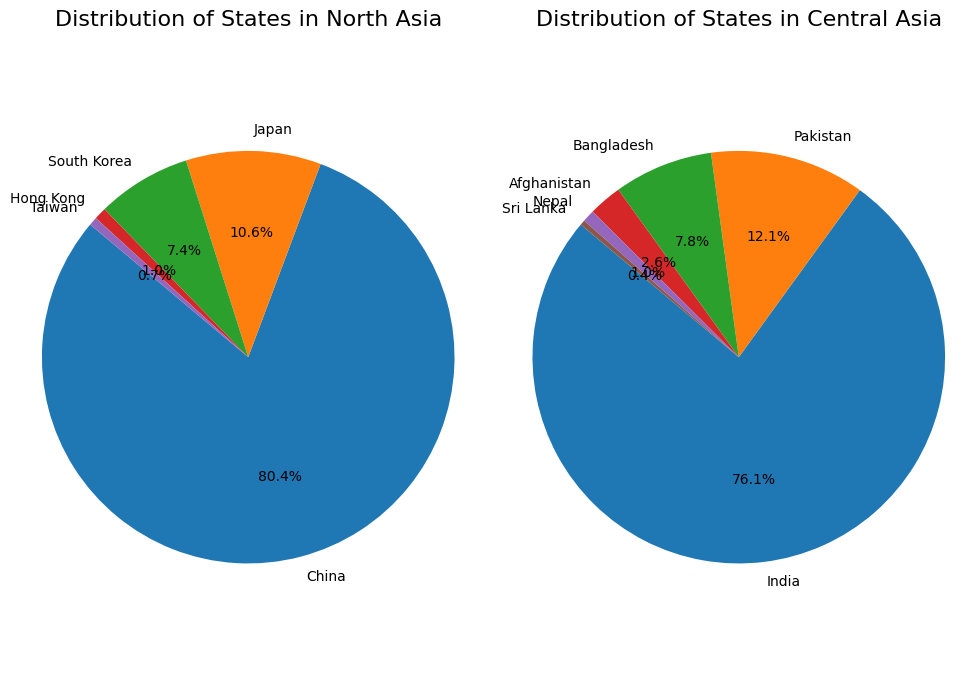

In [25]:
region1 = 'North Asia'
region2 = 'Central Asia'

# Filter the DataFrame for each region
filtered_df_region1 = EDA_df[EDA_df['Region'] == region1]
filtered_df_region2 = EDA_df[EDA_df['Region'] == region2]

# Group by 'State' and count occurrences for each region
state_counts_region1 = filtered_df_region1['Country'].value_counts()
state_counts_region2 = filtered_df_region2['Country'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 7))

# Plotting the pie chart for Region 1
axes[0].pie(state_counts_region1, labels=state_counts_region1.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title(f'Distribution of States in {region1}', fontsize=16)
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Plotting the pie chart for Region 2
axes[1].pie(state_counts_region2, labels=state_counts_region2.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f'Distribution of States in {region2}', fontsize=16)
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

There was a negative correlation between Profit and Discount. From the plot it is visible as the discount increase the profit is going down

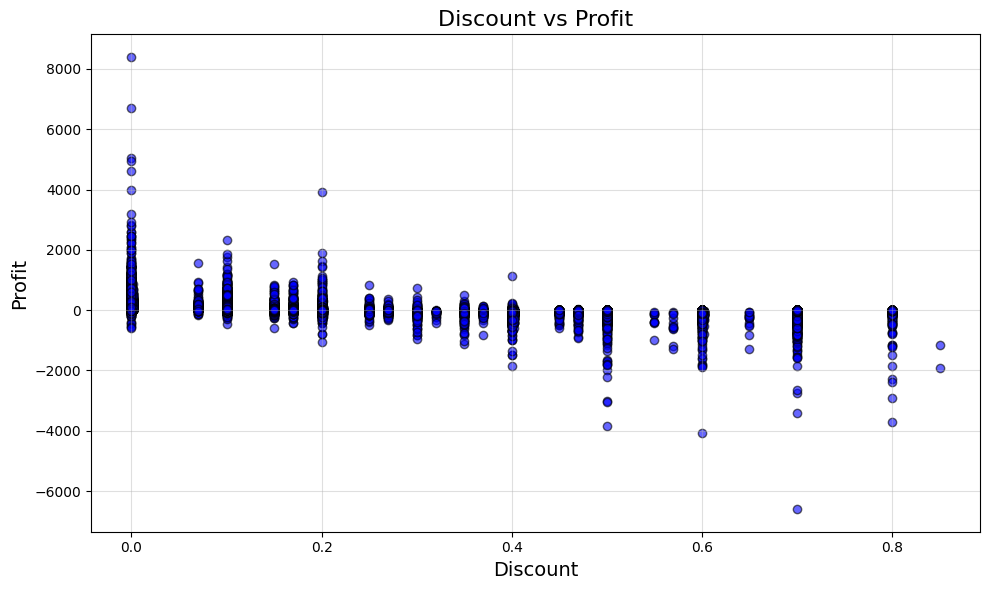

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(EDA_df['Discount'], EDA_df['Profit'], alpha=0.6, c='blue', edgecolor='k')
plt.title('Discount vs Profit', fontsize=16)
plt.xlabel('Discount', fontsize=14)
plt.ylabel('Profit', fontsize=14)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

In this plot we explored the relation between Order Priority and Shipping Mode. From the plot we can say that the most customer with the medium and low prioriy are choosing the standard class shipping mode.

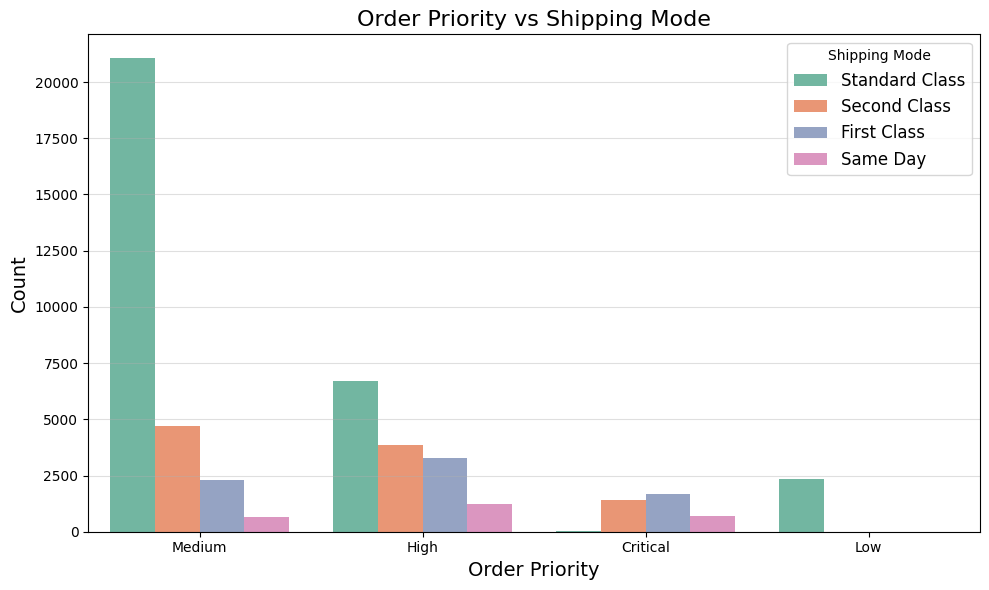

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(data=EDA_df, x='Order.Priority', hue='Ship.Mode', palette='Set2')
plt.title('Order Priority vs Shipping Mode', fontsize=16)
plt.xlabel('Order Priority', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Shipping Mode', fontsize=12)
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

In this plot we explored relation between shipping mode and cost. If a customer is choosing the First class or the Same day shipping mode they have to pay high shipping cost whereas the lowest shipping cost is for stadard class.

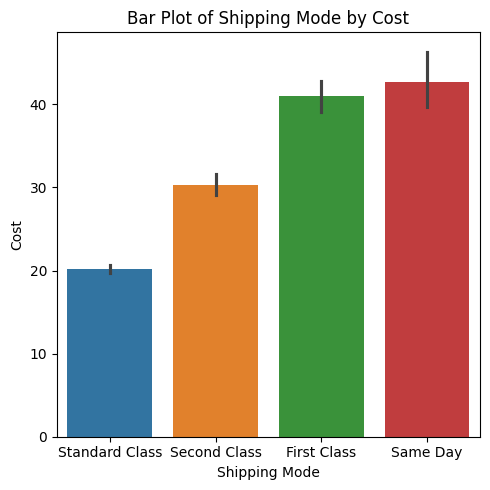

In [28]:
EDA_df['Ship.Mode']= EDA_df['Ship.Mode'].fillna('Unknown')
EDA_df['Shipping.Cost']= EDA_df['Shipping.Cost'].fillna(0)
plt.figure(figsize=(5, 5))
sns.barplot(x='Ship.Mode', y='Shipping.Cost', data=EDA_df, hue="Ship.Mode")
plt.title('Bar Plot of Shipping Mode by Cost')
plt.xlabel('Shipping Mode')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()

In this plot we explored the relation of Sales and Profit in percentage. This plot clearly shows that when the sales is high between 40-60% they are seeing high profit percent.

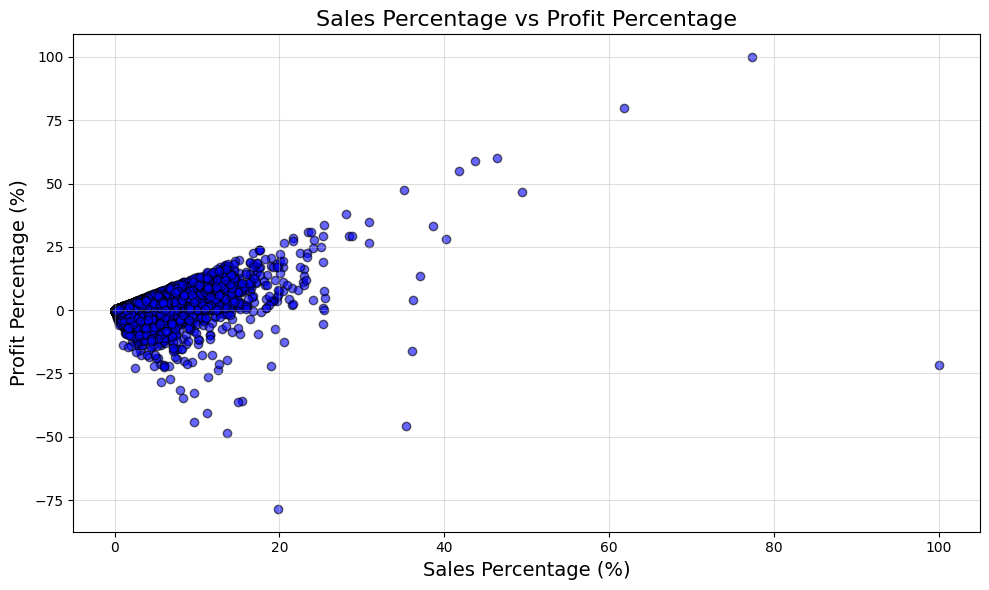

In [29]:
# Calculate percentage of Sales relative to the maximum Sales
EDA_df['Sales_Percentage'] = (EDA_df['Sales'] / EDA_df['Sales'].max()) * 100
EDA_df['Profit_Percentage'] = (EDA_df['Profit'] / EDA_df['Profit'].max()) * 100

# Scatter plot for Sales Percentage vs Profit
plt.figure(figsize=(10, 6))
plt.scatter(EDA_df['Sales_Percentage'], EDA_df['Profit_Percentage'], alpha=0.6, c='blue', edgecolor='k')
plt.title('Sales Percentage vs Profit Percentage', fontsize=16)
plt.xlabel('Sales Percentage (%)', fontsize=14)
plt.ylabel('Profit Percentage (%)', fontsize=14)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

In this plot we are checking which category items were maximum ordered, and here customers has mostly order office supplies.

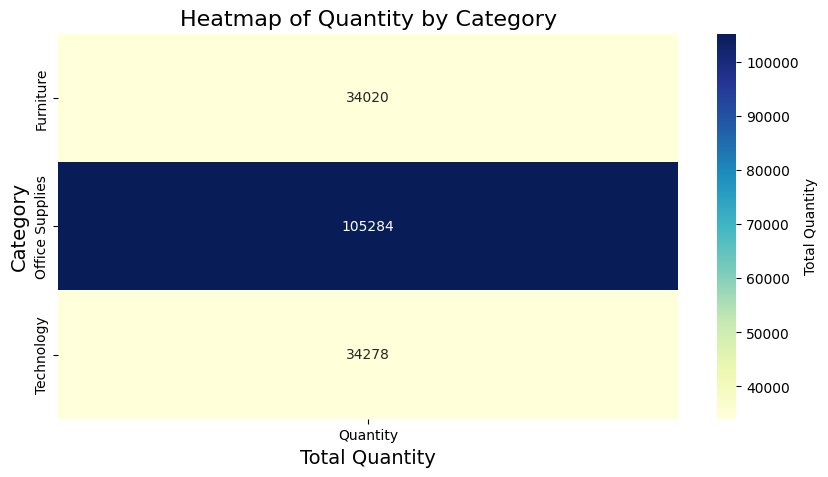

In [30]:
heatmap_data = EDA_df.pivot_table(values='Quantity', index='Category', aggfunc='sum')

# Create the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Total Quantity'})
plt.title('Heatmap of Quantity by Category', fontsize=16)
plt.xlabel('Total Quantity', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()

Phase III - Hypothesis Testing:

Sampling the data to proceed with testing:


In [31]:
HypTest_df=cleaned_df.sample(frac=0.1, random_state=20)

**1. Do different product segments perform significantly different in making sales?**

  ***Null hypothesis:*** There is no significant difference in average sales between different segments

  ***Alternative hypothesis:*** There is a significant difference in average sales between different segments

In [32]:
#Checking for Normality and Equal Variance:

#Shapiro's test for normality:
modes = HypTest_df['Ship.Mode'].unique()
for mode in modes:
    stat, p_value = shapiro(HypTest_df.loc[HypTest_df['Ship.Mode'] == mode, 'Sales'])
    print(f"Shapiro-Wilk Test for Ship Mode '{mode}': p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"  -> Data for '{mode}' is NOT normally distributed.")
    else:
        print(f"  -> Data for '{mode}' is normally distributed.")


Shapiro-Wilk Test for Ship Mode 'Standard Class': p-value = 0.0000
  -> Data for 'Standard Class' is NOT normally distributed.
Shapiro-Wilk Test for Ship Mode 'Second Class': p-value = 0.0000
  -> Data for 'Second Class' is NOT normally distributed.
Shapiro-Wilk Test for Ship Mode 'Same Day': p-value = 0.0000
  -> Data for 'Same Day' is NOT normally distributed.
Shapiro-Wilk Test for Ship Mode 'First Class': p-value = 0.0000
  -> Data for 'First Class' is NOT normally distributed.


In [33]:
#Levene's Test for Equal Variances:
groups = [HypTest_df.loc[HypTest_df['Ship.Mode'] == mode, 'Sales'] for mode in modes]
stat, p_value = levene(*groups)
print(f"\nLevene’s Test for Equal Variance: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("  -> Variances are NOT equal across groups.")
else:
    print("  -> Variances are equal across groups.")


Levene’s Test for Equal Variance: p-value = 0.5942
  -> Variances are equal across groups.


Test for Normality failed stating that the data is not normally distributed hence **Kruskal-Wallis's** non-parametric test is carried out to test our Hypothesis.

Kruskal-Wallis Test for Sales by Shipping Mode
Test statistic: 0.71
P-value: 0.8714
Fail to reject the null hypothesis: There is no significant difference in sales across shipping modes.


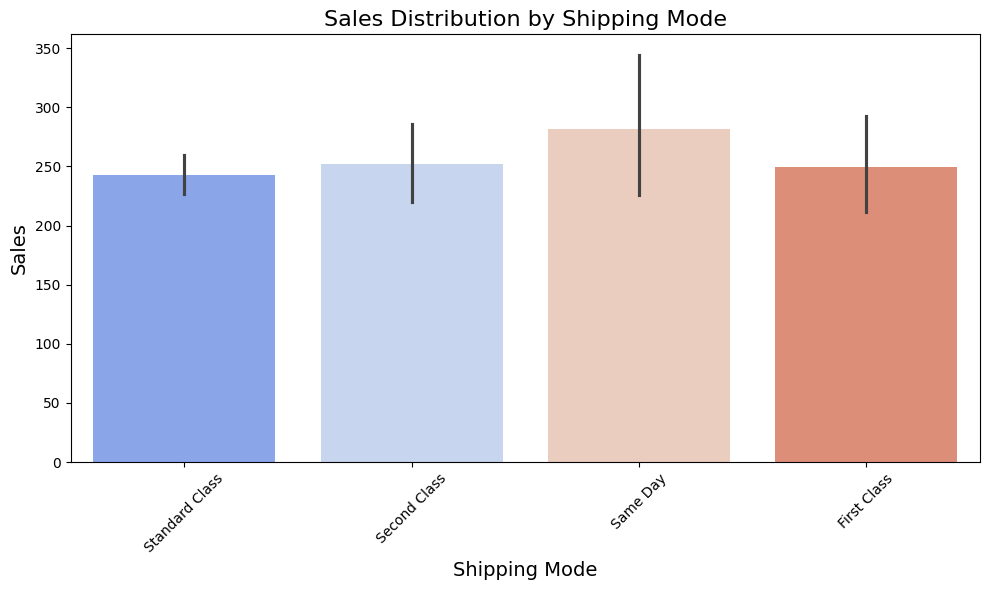

In [34]:
shipping_modes = HypTest_df['Ship.Mode'].unique()
sales_by_mode = [HypTest_df.loc[HypTest_df['Ship.Mode'] == mode, 'Sales'] for mode in shipping_modes]

#Kruskal-Wallis test
stat, p_value = kruskal(*sales_by_mode)

alpha = 0.05
print("Kruskal-Wallis Test for Sales by Shipping Mode")
print(f"Test statistic: {stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in sales across shipping modes.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in sales across shipping modes.")

plt.figure(figsize=(10, 6))
sns.barplot(x='Ship.Mode', y='Sales', data=HypTest_df, palette='coolwarm')
plt.title('Sales Distribution by Shipping Mode', fontsize=16)
plt.xlabel('Shipping Mode', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. Do different product categories perform significantly different in making sales?

    ***Null hypothesis:*** There is no significant difference in average sales between different product categories

    ***Alternative hypothesis:*** There is a significant difference in average sales between different product categories

In [35]:
#Checking for Normality and Equal Variance:

#Shapiro's test for normality:

product_categories = HypTest_df['Category'].unique()
for category in product_categories:
    stat, p_value = shapiro(HypTest_df.loc[HypTest_df['Category'] == category, 'Sales'].dropna())
    print(f"Shapiro-Wilk Test for category '{category}': p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"  -> Data for '{category}' is NOT normally distributed.")
    else:
        print(f"  -> Data for '{category}' is normally distributed.")

Shapiro-Wilk Test for category 'Office Supplies': p-value = 0.0000
  -> Data for 'Office Supplies' is NOT normally distributed.
Shapiro-Wilk Test for category 'Furniture': p-value = 0.0000
  -> Data for 'Furniture' is NOT normally distributed.
Shapiro-Wilk Test for category 'Technology': p-value = 0.0000
  -> Data for 'Technology' is NOT normally distributed.


In [36]:
sales_by_category = [HypTest_df.loc[HypTest_df['Category'] == category, 'Sales'].dropna() for category in product_categories]

#Levene's test for equal variances
stat, p_value = levene(*sales_by_category)
print(f"\nLevene’s Test for Equal Variances: p-value = {p_value:.4f}")

if p_value < 0.05:
    print("  -> Variances are NOT equal across categories.")
else:
    print("  -> Variances are equal across categories.")


Levene’s Test for Equal Variances: p-value = 0.0000
  -> Variances are NOT equal across categories.


Since the test for Normality and Equal Variance failed we follow **Kruskal-Wallis** test to carry out our Hypothesis testing.


Kruskal-Wallis Test for Sales by Product Category
Test statistic: 1399.90
P-value: 0.0000
Reject the null hypothesis: There is a significant difference in sales across product categories.


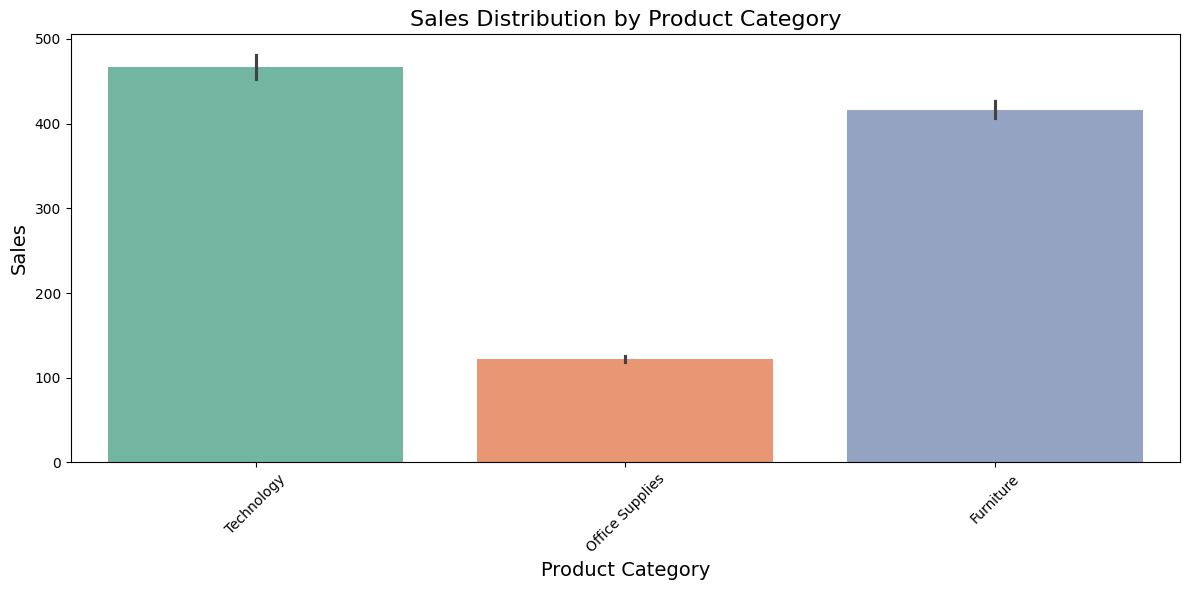

In [37]:
#Kruskal-Wallis Test (Non-Parametric Test)

stat, p_value = kruskal(*sales_by_category)
alpha = 0.05
print("\nKruskal-Wallis Test for Sales by Product Category")
print(f"Test statistic: {stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in sales across product categories.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in sales across product categories.")

plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Sales', data=EDA_df, palette='Set2')
plt.title('Sales Distribution by Product Category', fontsize=16)
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()